In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

import json

from sklearn.metrics import classification_report

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model training 

In [17]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path":  "../datasets/UTS/NAB/Twitter_volume_AAPL",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 10,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.1,
  "beta_end": 1,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

sequence_length = 1500
input_size = 1  # Assuming 1D time series data


In [16]:
# Initialize the TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32, 64, 128 ,256,128,64,32 ,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=150, stride=1,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=1500, stride=100, normalize=False) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

Training model...


Epoch 9: 100%|██████████| 487/487 [00:16<00:00, 30.90it/s, loss=2.7e+3, step=9]

eval timesteps tensor([47, 27, 50,  6, 96,  1, 65, 80, 62, 95, 78, 73, 27, 37, 93, 21])


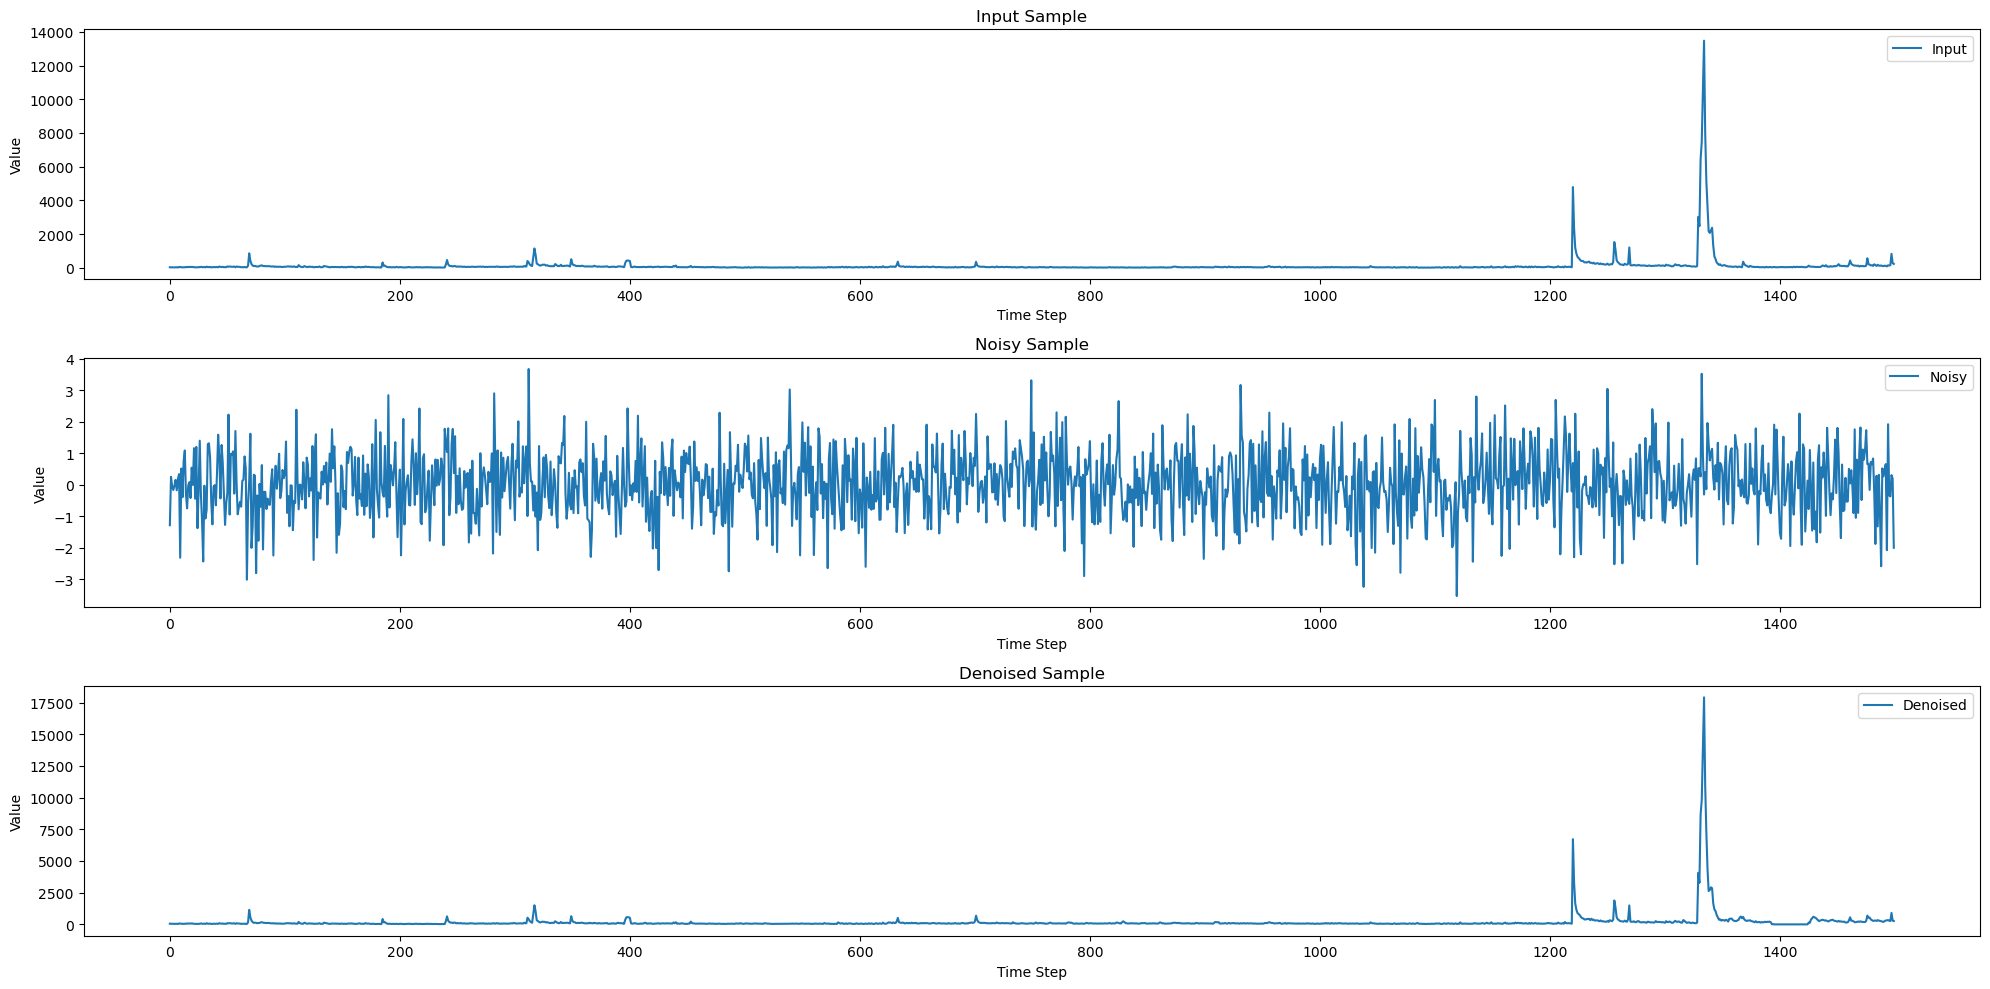

Epoch 9: 100%|██████████| 487/487 [00:16<00:00, 29.61it/s, loss=2.7e+3, step=9]


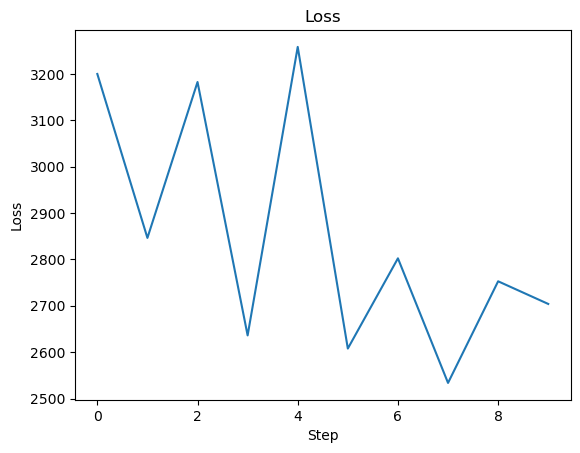

Model saved at output/10/model.pth
Losses saved at output/10/losses.json
Config saved at output/10/config.json


<Figure size 640x480 with 0 Axes>

In [45]:
# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
      
for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, labels) in enumerate(dataloader): # timestamps,
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) #* std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order the timesteps
        timesteps = timesteps.sort().values
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        #print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": global_step}
    losses.append(loss.detach().item())
    progress_bar.set_postfix(**logs)
    global_step += 1
    
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample,  labels) in enumerate(tqdm(test_dataloader)):#timestamps,
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)

                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()
    
    
# save the model, losses and all the config parameters in a directory 
import os
import json

# output dir contains the num epochs 
output_dir = os.path.join(config.output_dir, str(config.num_epochs))
# create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True) 

# Save the model
model_path = os.path.join(output_dir, "model.pth")
torch.save(model.state_dict(), model_path)

# Save the losses and the lother parameters in a json file 
losses_path = os.path.join(output_dir, "losses.json")
with open(losses_path, "w") as f:
    json.dump(losses, f)
    
# Save the config 
config_path = os.path.join(output_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(vars(config), f)

# save the losses plot
# plot the loss
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()
losses_plot_path = os.path.join(output_dir, "losses_plot.png")
plt.savefig(losses_plot_path)
    
print("Model saved at", model_path)
print("Losses saved at", losses_path)
print("Config saved at", config_path)



# Evaluation and anomaly prediction one sample 

In [14]:
model.eval()
eval_batch_size = config.eval_batch_size

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=1500, stride=1500, normalize=False) #mean=dataset.mean, std=dataset.std)

# print the len of test dataset
print("len", len(test_dataset))

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)


for step, (sample,labels) in enumerate(tqdm(test_dataloader)): #  timestamps, 
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)

        timesteps = torch.tensor([50])
        
        noise = torch.randn_like(sample) 
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(noisy_sample)

        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()

        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        print("std_data", std_data)
        threshold = std_data

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
        
        labels = labels.cpu().numpy()

        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()

        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")
        from sklearn.metrics import classification_report
        print(classification_report(labels[0], outliers[0]))

len 5


0it [00:00, ?it/s]


In [41]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    f1 = 0
    auprc = 0
    precision = 0
    recall = 0
    taille = 0
    
    for step, (sample, labels) in tqdm(enumerate(test_dataloader)): # timestamps,
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
            
            labels = labels.cpu().numpy()
                
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
            #print("eval timesteps", timesteps)
        
            std_data = torch.std(sample)
            noise_level = 0.5
            noise = torch.randn_like(sample) * std_data * noise_level
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(sample) *2
            

            # computing the best threshold for the outliers
            for i in range(len(sample)):              
                best_f1 = 0
                best_threshold = 0
                best_auprc = 0
                best_precision = 0
                best_recall = 0
                
                for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                    outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                    
                    f1_temp, precision_temp, recall_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    
                    if f1_temp > best_f1:
                        best_f1 = f1_temp
                        best_threshold = threshold
                        best_precision = precision_temp
                        best_recall = recall_temp
                        
                """print("Best threshold:", best_threshold)
                print("Best F1 score:", best_f1)
                print("Best AUPRC score:", best_auprc)
                print("Best Precision score:", best_precision)
                print("Best Recall score:", best_recall)"""
            
            if best_f1 > 0:  
                f1 += best_f1
                precision += best_precision
                recall += best_recall
                taille += 1
                        # plot one random sample 
            if step == 0:
                plot_samples(sample[0], noisy_sample[0], denoised_sample[0])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
    f1 = f1 / taille
    auprc = auprc / taille
    precision = precision / taille
    recall = recall / taille
            
                
    print("F1 score:", f1 )
    print("AUPRC score:",auprc)
    print("Precision score:", precision)
    print("Recall score:", recall)
            

            


In [42]:
tester(config, model, noise_scheduler, test_dataset)

0it [00:00, ?it/s]


NameError: name 'plot_samples' is not defined

# Saving figures and results : 

## WSD107

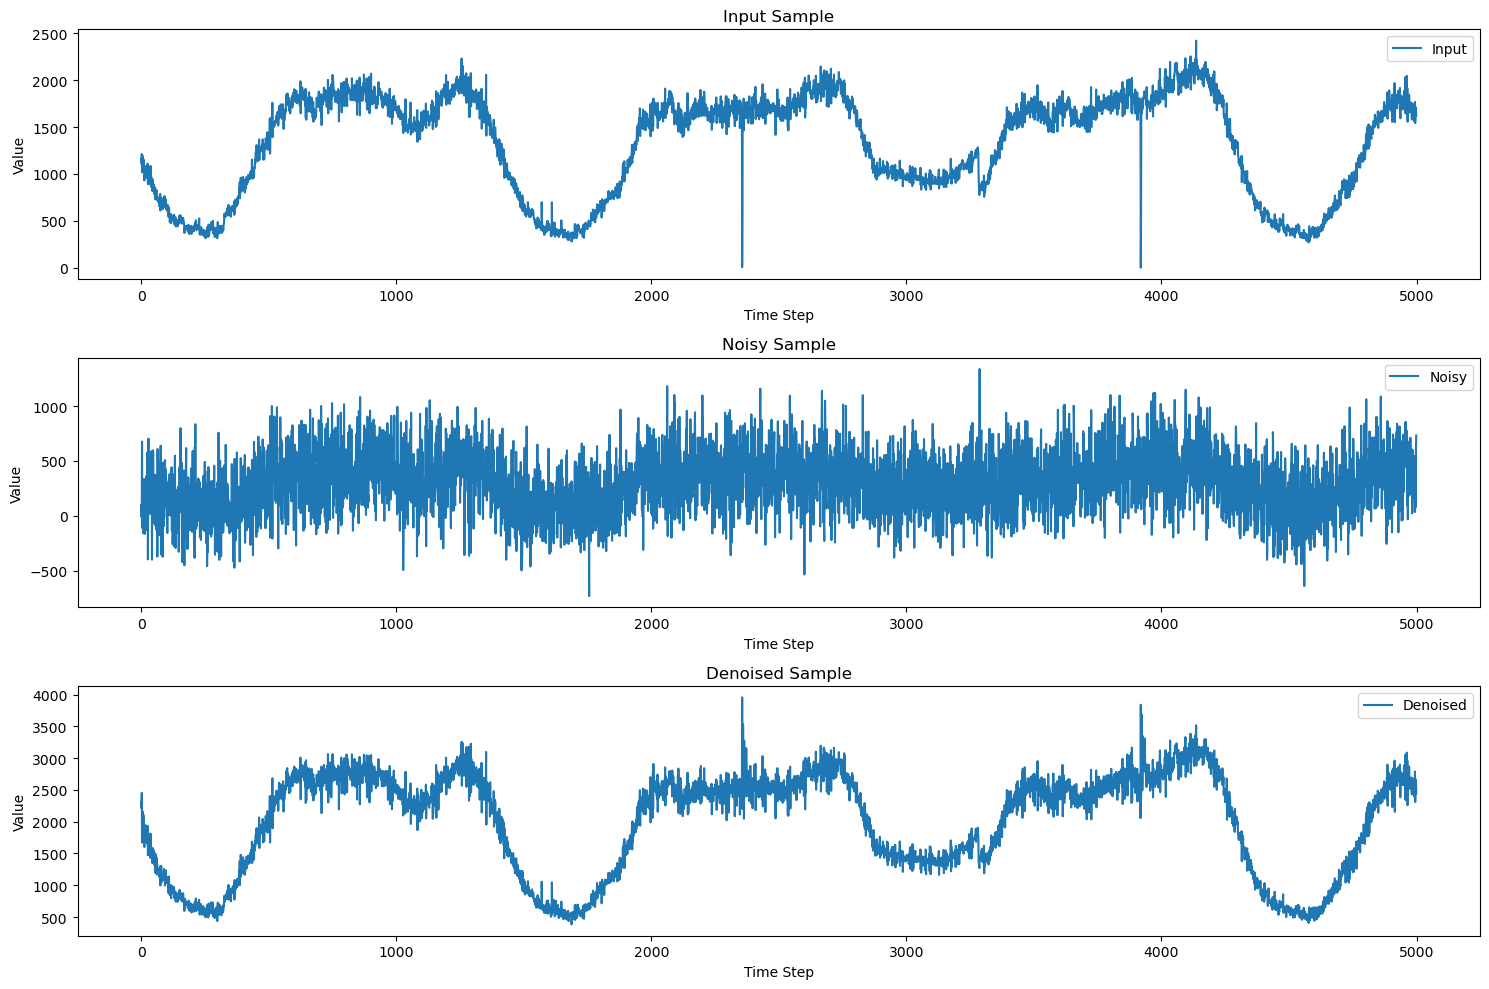

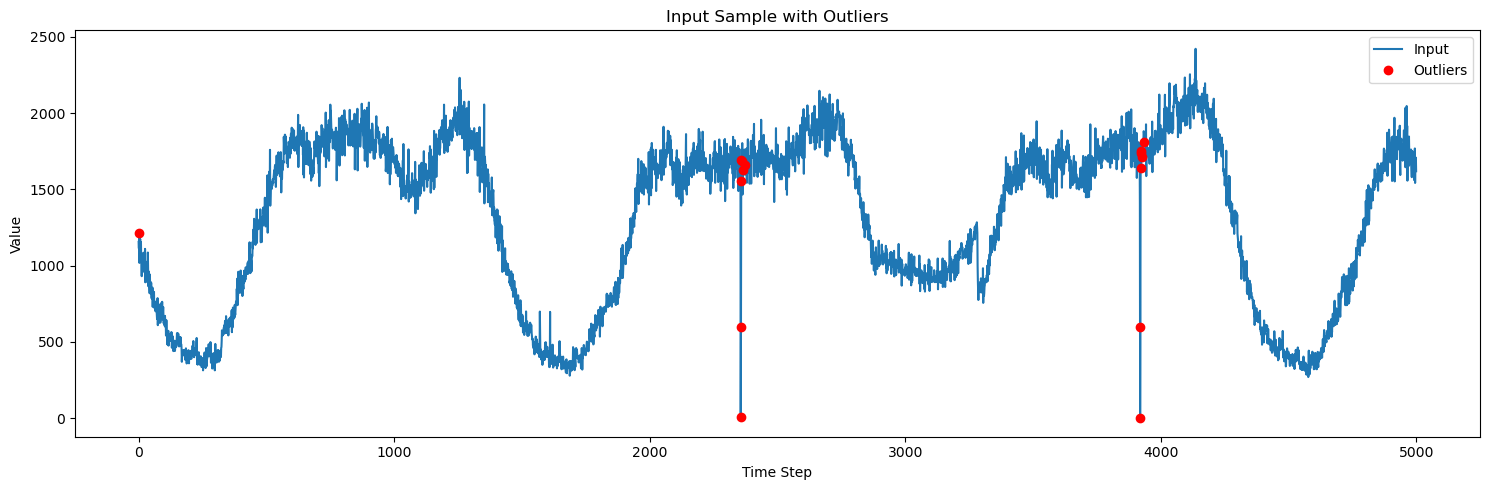

eval timesteps tensor([537, 118,  19, 188, 726, 399, 723, 277, 863, 421, 150, 248, 968, 352,
        256,  21])
Best threshold: tensor(1214.1018)
Best F1 score: 0.4489795918367347
Best AUPRC score: 0.2418549019607843
Best Precision score: 0.7333333333333333
Best Recall score: 0.3235294117647059
Best threshold: tensor(1214.1018)
Best F1 score: 0.3333333333333333
Best AUPRC score: 0.1385217391304348
Best Precision score: 0.55
Best Recall score: 0.2391304347826087
Best threshold: tensor(1214.1018)
Best F1 score: 0.26506024096385544
Best AUPRC score: 0.08902645502645501
Best Precision score: 0.4074074074074074
Best Recall score: 0.19642857142857142
Best threshold: tensor(1108.5278)
Best F1 score: 0.3488372093023256
Best AUPRC score: 0.14212857142857144
Best Precision score: 0.5
Best Recall score: 0.26785714285714285
Best threshold: tensor(1108.5278)
Best F1 score: 0.2988505747126437
Best AUPRC score: 0.10427777777777776
Best Precision score: 0.3333333333333333
Best Recall score: 0.2708333333333333
Best threshold: tensor(1214.1018)
Best F1 score: 0.2937062937062937
Best AUPRC score: 0.11151052631578946
Best Precision score: 0.4375
Best Recall score: 0.22105263157894736
Best threshold: tensor(1108.5278)
Best F1 score: 0.35064935064935066
Best AUPRC score: 0.14366244424620875
Best Precision score: 0.4576271186440678
Best Recall score: 0.28421052631578947
Best threshold: tensor(1108.5278)
Best F1 score: 0.30917874396135264
Best AUPRC score: 0.11097254021698467
Best Precision score: 0.32323232323232326
Best Recall score: 0.2962962962962963
Best threshold: tensor(1214.1018)
Best F1 score: 0.24539877300613497
Best AUPRC score: 0.07307727546714889
Best Precision score: 0.25316455696202533
Best Recall score: 0.23809523809523808
Best threshold: tensor(1108.5278)
Best F1 score: 0.35294117647058826
Best AUPRC score: 0.14386813186813188
Best Precision score: 0.46153846153846156
Best Recall score: 0.2857142857142857
Best threshold: tensor(1214.1018)
Best F1 score: 0.3076923076923077
Best AUPRC score: 0.11631966873706004
Best Precision score: 0.43478260869565216
Best Recall score: 0.23809523809523808
Best threshold: tensor(1214.1018)
Best F1 score: 0.30303030303030304
Best AUPRC score: 0.10299259259259258
Best Precision score: 0.3333333333333333
Best Recall score: 0.2777777777777778
Best threshold: tensor(1214.1018)
Best F1 score: 0.42105263157894735
Best AUPRC score: 0.2039034213098729
Best Precision score: 0.6060606060606061
Best Recall score: 0.3225806451612903
Best threshold: tensor(1214.1018)
Best F1 score: 0.4233576642335766
Best AUPRC score: 0.18830085470085473
Best Precision score: 0.4461538461538462
Best Recall score: 0.4027777777777778
Best threshold: tensor(1214.1018)
Best F1 score: 0.32323232323232326
Best AUPRC score: 0.12260298507462686
Best Precision score: 0.23880597014925373
Best Recall score: 0.5
Best threshold: tensor(1214.1018)
Best F1 score: 0.47368421052631576
Best AUPRC score: 0.23758260869565218
Best Precision score: 0.6
Best Recall score: 0.391304347826087
F1 score: 0.34368654551477423
AUPRC score: 0.14191265590930915
Precision score: 0.4447670561777277
Recall score: 0.2972302286753181

## NAB 

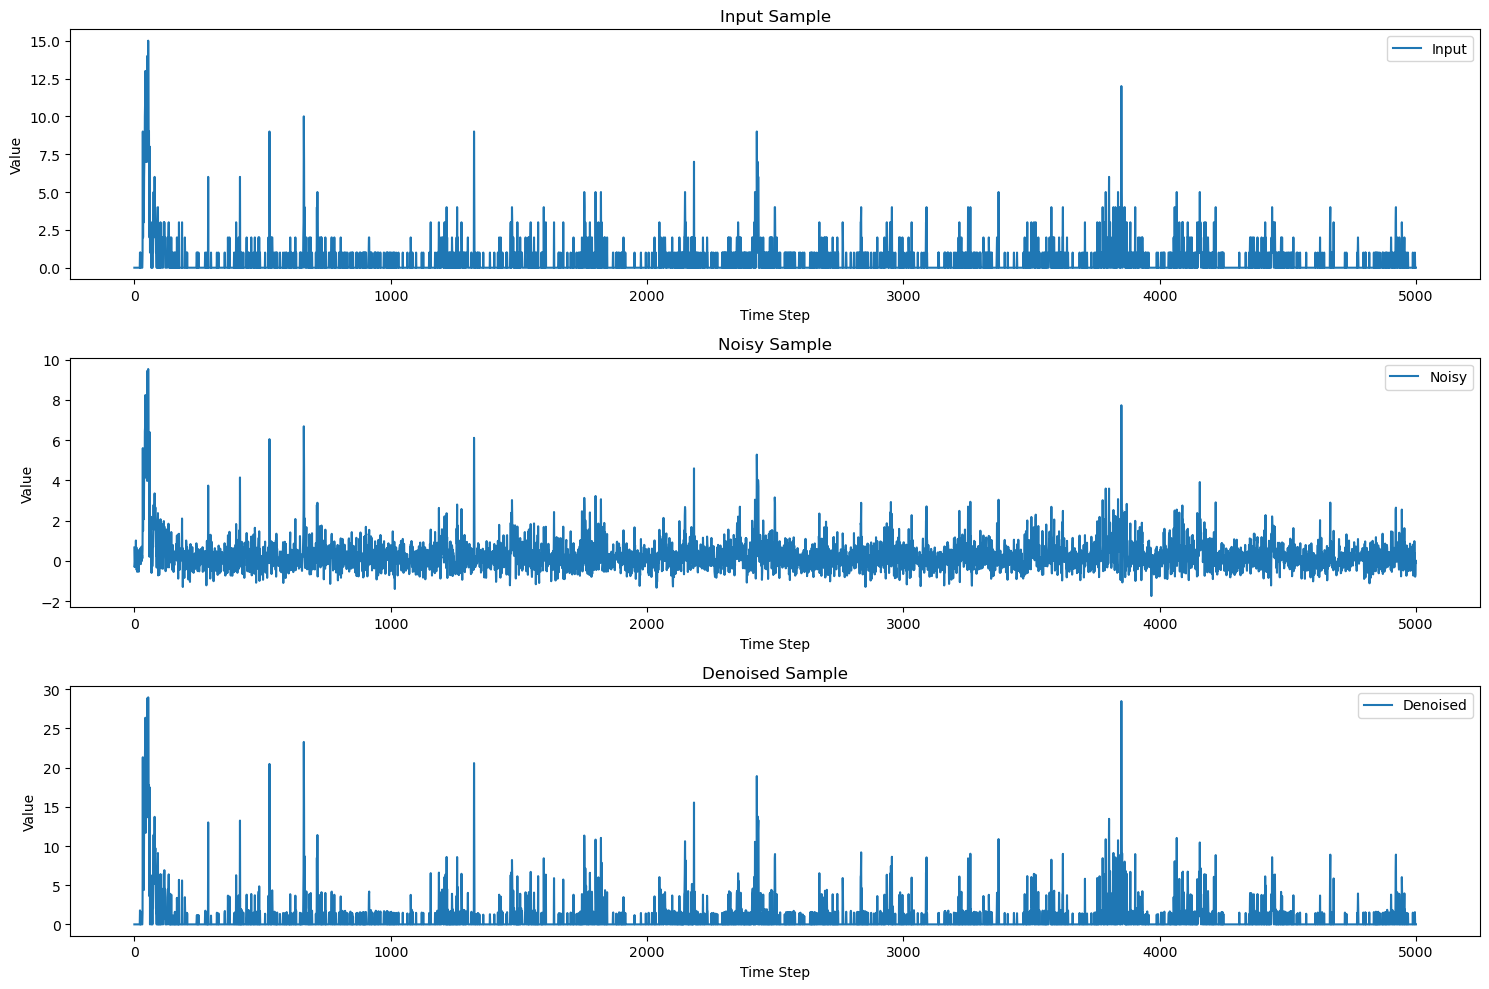

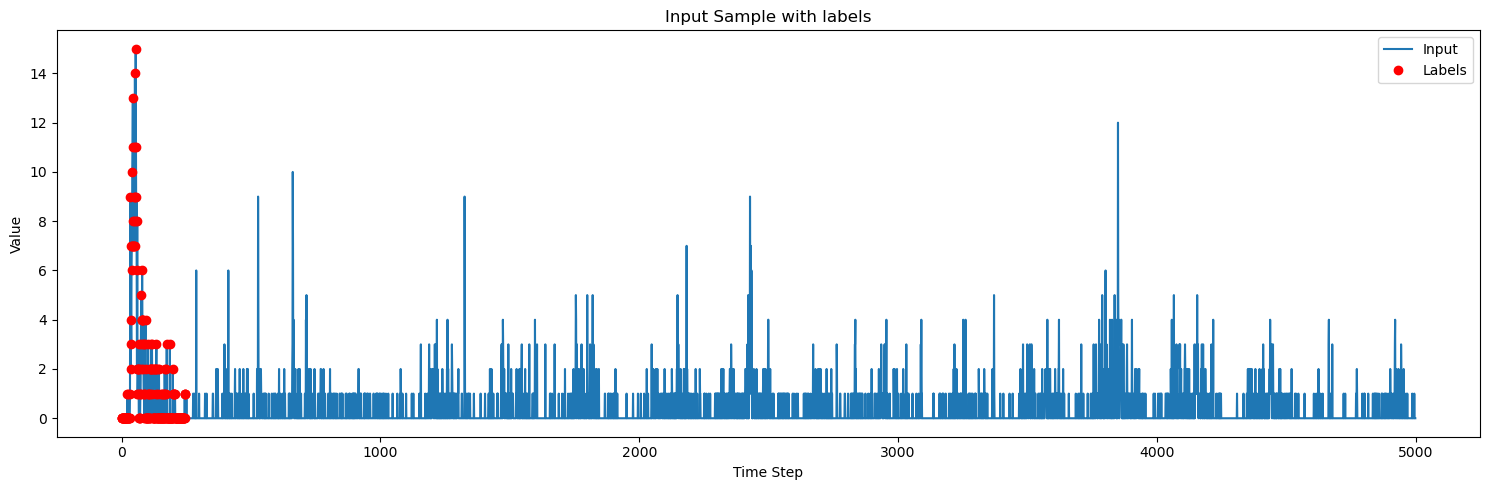

eval timesteps tensor([634, 451, 626, 721])
Best threshold: tensor(2.0974)
Best F1 score: 0.21176470588235294
Best AUPRC score: 0.08645831779102034
Best Precision score: 0.25280898876404495
Best Recall score: 0.18218623481781376
Best threshold: tensor(1.1039)
Best F1 score: 0.027586206896551724
Best AUPRC score: 0.015505956613219183
Best Precision score: 0.01675977653631285
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.5520)
Best F1 score: 0.1319073083778966
Best AUPRC score: 0.08149127348806288
Best Precision score: 0.08638132295719844
Best Recall score: 0.27889447236180903
Best threshold: tensor(0.5520)
Best F1 score: 0.13012895662368112
Best AUPRC score: 0.08106765017749298
Best Precision score: 0.08486238532110092
Best Recall score: 0.27889447236180903
F1 score: 0.1253467944451206
AUPRC score: 0.06613079951744885
Precision score: 0.11020311839466429
Recall score: 0.20447431436587743

# Complete Evaluation

In [2]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [3]:
# plot functions : 
def plot_samples(sample, noisy_sample, denoised_sample):  
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    ax = axs[0]
    ax.plot(sample.cpu().numpy())
    ax.set_title("Input Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Input"])
    
    ax = axs[1]
    ax.plot(noisy_sample.cpu().numpy())
    ax.set_title("Noisy Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Noisy"])
    
    ax = axs[2]
    ax.plot(denoised_sample.detach().numpy())
    ax.set_title("Denoised Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Denoised"])
    
    plt.tight_layout()
    plt.show()

def plot_predictions(sample, denoised_sample, outliers, labels):
    
    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    outlier_indices = np.where(outliers[0] == 1)[0]
    ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

    ax.set_title("Input Sample with Outliers")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    label_indices = np.where(labels[0] == True)[0]
    ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
    
    ax.set_title("Input Sample with labels")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def trainer(config, model, noise_scheduler, dataset):
    
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )

    # the training loop
    global_step = 0
    frames = []
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        #progress_bar = tqdm(total=len(dataloader))
        #progress_bar.set_description(f"Epoch {epoch}")
        
        for step, (batch, labels) in enumerate(dataloader):
            std_data = torch.std(batch)
            
            noise = torch.randn_like(batch)
            
            timesteps = torch.randint(
                0, noise_scheduler.num_timesteps, (batch.shape[0],)
            ).long()
            
            #print("timesteps", timesteps)
            
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            
            noisy = noisy.unsqueeze(-1) 
            # pred noise from the model
            noise_pred = model(noisy)
            
            #print("noise_pred", noise_pred.shape)
            batch = batch.unsqueeze(-1)
            
            loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        #progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        #progress_bar.set_postfix(**logs)
        global_step += 1
    
    #progress_bar.close()              
    return model, losses

In [5]:
def train_tracker(config, model, dataset):
    # save the model, losses, and all the config parameters in a directory 
    import os
    import json
    import matplotlib.pyplot as plt

    # output dir contains the num epochs 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    # create the directory if it does not exist
    os.makedirs(output_dir, exist_ok=True) 

    # Save the model
    model_path = os.path.join(output_dir, "model.pth")
    torch.save(model.state_dict(), model_path)

    # Save the losses and other parameters in a json file 
    losses_path = os.path.join(output_dir, "losses.json")
    with open(losses_path, "w") as f:
        json.dump(losses, f)
        
    # Save the config 
    config_path = os.path.join(output_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(vars(config), f)

    # Save the losses plot
    # Plot the loss
    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    
    # Save the plot before showing it
    losses_plot_path = os.path.join(output_dir, "losses_plot.png")
    plt.savefig(losses_plot_path)
    
    # Display the plot
    plt.show()
        
    """print("Model saved at", model_path)
    print("Losses saved at", losses_path)
    print("Config saved at", config_path)
    print("Loss plot saved at", losses_plot_path)"""

    return model, losses


In [6]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    for step, (sample, labels) in enumerate(test_dataloader):
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
                
            #noise_level = 0.5
            #noise = torch.randn_like(sample) * std_data * noise_level
            noise = torch.randn_like(sample) 
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(noisy_sample)

            labels = labels.cpu().numpy()
                
            best_f1 = 0
            best_threshold = 0
            best_auprc = 0
            # computing the best threshold for the outliers
            for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                
                f1 = 0
                auprc = 0
                
                # calculate the f1 score and auprc score
                for i in range(len(outliers)):
                    f1_temp, auprc_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    f1 += f1_temp
                    auprc += auprc_temp
                
                f1 = f1 / len(outliers)
                auprc = auprc / len(outliers)
         
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_auprc = auprc
                
            print("F1 score:", best_f1)
            print("AUPRC score:", best_auprc)
            
            # save results in output directory
            results = {
                "std_data": std_data.item(),  # Convert tensor to a scalar
                "f1": best_f1,
                "auprc": best_auprc,
                "threshold": best_threshold  # Convert tensor to a scalar
            }
            
            # Convert the results dictionary to a DataFrame and concatenate with the existing results_df
            results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
            
            # plot one random sample 
            if step == 10:
                plot_samples(sample[10], noisy_sample[10], denoised_sample[10])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
                
    # save as a csvfile 
    results_df.to_csv(os.path.join(output_dir, "results.csv"))
    
    average_f1 += best_f1
    average_auprc += best_auprc
            
    average_f1 = average_f1 / len(test_dataloader)
    average_auprc = average_auprc / len(test_dataloader)
    
    print("Average F1 score:", average_f1)
    print("Average AUPRC score:", average_auprc)
    
    return average_f1, average_auprc


In [7]:
# f1 score and auprc score for 0/1 classification

from sklearn.metrics import f1_score, average_precision_score

# define the function to calculate the f1 score and auprc score
def calculate_f1_auprc_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0 ) #, labels=np.unique(y_pred) zero_division=np.nan
    auprc = average_precision_score(y_true, y_pred, average='weighted')
    return f1, auprc

In [8]:
# metrics 
import torch
import numpy as np

def z_score_outliers(sample, denoised_sample, threshold=3.0):
    diff = sample - denoised_sample
    mean = torch.mean(diff)
    std = torch.std(diff)
    z_scores = torch.abs((diff - mean) / std)
    outliers = (z_scores > threshold).cpu().numpy()
    return outliers

def modified_z_score_outliers(sample, denoised_sample, threshold=3.5):
    diff = sample - denoised_sample
    median = torch.median(diff)
    mad = torch.median(torch.abs(diff - median))
    modified_z_scores = 0.6745 * torch.abs(diff - median) / mad
    outliers = (modified_z_scores > threshold).cpu().numpy()
    return outliers

def iqr_outliers(sample, denoised_sample, threshold=1.5):
    diff = sample - denoised_sample
    q1 = torch.quantile(diff, 0.25)
    q3 = torch.quantile(diff, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = ((diff < lower_bound) | (diff > upper_bound)).cpu().numpy()
    
    # Calculate anomaly scores
    anomaly_scores = torch.abs(diff) / iqr
    anomaly_scores = anomaly_scores.cpu().numpy()
    
    return outliers, anomaly_scores

# Example usage:
sample = torch.randn(1000)
denoised_sample = torch.randn(1000)

z_score_out = z_score_outliers(sample, denoised_sample)
mod_z_score_out = modified_z_score_outliers(sample, denoised_sample)
iqr_out,_ = iqr_outliers(sample, denoised_sample)

print(f"Z-score outliers: {z_score_out.sum()}")
print(f"Modified Z-score outliers: {mod_z_score_out.sum()}")
print(f"IQR outliers: {iqr_out.sum()}")

Z-score outliers: 4
Modified Z-score outliers: 2
IQR outliers: 4


In [9]:
import torch
import numpy as np
from scipy.ndimage import gaussian_filter1d

def iqr_collective_outliers(sample, denoised_sample, threshold=1.5, window_size=10, density_threshold=0.5, smoothing_sigma=None):
    # Step 1: Calculate point-wise differences
    diff = sample - denoised_sample
    
    # Step 2: Identify initial outliers using IQR method
    q1 = torch.quantile(diff, 0.25)
    q3 = torch.quantile(diff, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    initial_outliers = ((diff < lower_bound) | (diff > upper_bound))
    
    # Step 3: Calculate outlier density using a sliding window
    outlier_density = torch.zeros_like(diff, dtype=torch.float32)
    for i in range(len(diff)):
        start = max(0, i - window_size // 2)
        end = min(len(diff), i + window_size // 2)
        outlier_density[i] = torch.mean(initial_outliers[start:end].float())
    
    # Step 4: Apply Gaussian smoothing to the density if smoothing_sigma is provided
    if smoothing_sigma is not None:
        smoothed_density = torch.from_numpy(
            gaussian_filter1d(outlier_density.cpu().numpy(), sigma=smoothing_sigma)
        ).to(diff.device)
    else:
        smoothed_density = outlier_density
    
    # Step 5: Identify collective outliers based on density
    collective_outliers = smoothed_density > density_threshold
    
    return collective_outliers.cpu().numpy()

# Example usage:
sample = torch.randn(1000)
denoised_sample = torch.randn(1000)

# Add some collective anomalies
sample[300:350] += 5
sample[600:630] += 4

# Detect collective outliers with and without smoothing
collective_outliers_smooth = iqr_collective_outliers(sample, denoised_sample, smoothing_sigma=2.0)
collective_outliers_no_smooth = iqr_collective_outliers(sample, denoised_sample, smoothing_sigma=None)

print(f"Collective outliers detected (with smoothing): {collective_outliers_smooth.sum()}")
print(f"Collective outliers detected (without smoothing): {collective_outliers_no_smooth.sum()}")


Collective outliers detected (with smoothing): 46
Collective outliers detected (without smoothing): 44


# One by one training 

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
import pandas as pd
import json

def train_model(config, model, noise_scheduler, train_dataloader):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    losses = []
    
    for epoch in tqdm(range(config.num_epochs), desc="Training"):
        model.train()
        epoch_losses = []
        for step, (batch, labels) in enumerate(train_dataloader):
            noise = torch.randn_like(batch)
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long()
            timesteps = torch.sort(timesteps).values
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            noisy = noisy.unsqueeze(-1)
            noise_pred = model(noisy)
            batch = batch.unsqueeze(-1)
            loss = F.mse_loss(noise_pred, batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{config.num_epochs}, Loss: {avg_loss:.4f}")
    
    return model, losses

def test_model(config, model, noise_scheduler, test_dataloader):
    model.eval()
    all_labels = []
    all_scores = []
    
    for step, (sample, labels) in enumerate(tqdm(test_dataloader, desc="Testing")):
        with torch.no_grad():
            timesteps = torch.tensor([70])
            noise = torch.randn_like(sample)
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(noisy_sample)
            iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
            labels = labels.cpu().numpy()
            all_labels.extend(labels.reshape(-1))
            all_scores.extend(iqr_scores.reshape(-1))
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    return all_labels, all_scores, fpr, tpr, roc_auc

def process_directory(data_path, base_config, model_class, noise_scheduler):
    print(f"\nProcessing directory: {os.path.basename(data_path)}")
    
    base_config["data_path"] = data_path
    config = Config(base_config)
    
    # Set up datasets and dataloaders
    train_dataset = TimeSeriesDataset(config.data_path, sequence_length=sequence_length, stride=stride, normalize=False)
    test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length, stride=sequence_length, normalize=False)
    
    train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=False, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    # Initialize and train the model
    model = model_class(
        num_inputs=input_size,
        num_channels=[32,64,128,256,128,64,32,1],
        kernel_size=3,
        dropout=0.2,
        causal=True,
        use_norm='weight_norm',
        activation='relu',
        kernel_initializer='xavier_uniform',
        use_skip_connections=False,
        input_shape='NLC'
    )
    
    model, losses = train_model(config, model, noise_scheduler, train_dataloader)
    
    # Test the model
    all_labels, all_scores, fpr, tpr, roc_auc = test_model(config, model, noise_scheduler, test_dataloader)
    
    print(f"\nClassification report for {os.path.basename(data_path)}")
    print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Save model and results
    output_dir = os.path.join(config.output_dir, os.path.basename(data_path), str(config.num_epochs))
    os.makedirs(output_dir, exist_ok=True)
    
    torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))
    
    with open(os.path.join(output_dir, "losses.json"), "w") as f:
        json.dump(losses, f)
    
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(vars(config), f)
    
    return {
        'dir': os.path.basename(data_path),
        'labels': all_labels,
        'scores': all_scores,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'losses': losses
    }


## WSD dataset

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [ ]:
import os

data_folder = "../datasets/UTS/NAB"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


# NAB dataset - all in one 

In [11]:

base_config = {
  "data_path":  "../datasets/UTS/NAB",
  "output_dir": "output_NAB2",
  "train_batch_size": 2,
  "eval_batch_size": 1,
  "num_epochs": 15,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.05,
  "beta_end": 0.1,
  "save_model_epochs": 1
}

sequence_length = 3000
input_size = 1  # Assuming 1D time series data
stride = 100


In [12]:
# all in one training and testing
import os
    
config = Config(base_config)

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32,64, 128, 256,128,64,32,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"


def trainer_all_in_one(config, model, noise_scheduler,data_folder):
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )
    
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        for root, dirs, files in os.walk(data_folder):
            for dir in dirs:
                data_path = os.path.join(data_folder, dir)
            
                # change datapath in the config
                base_config["data_path"] = data_path
                
                # Create Config object
                config = Config(base_config)
                
                # Set up dataset and dataloader
                dataset = TimeSeriesDataset(config.data_path,sequence_length=sequence_length, stride=stride,normalize=False)
                
                dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
                
                for step, (batch, labels) in enumerate(dataloader):
                    
                    noise = torch.randn_like(batch)
                    
                    timesteps = torch.randint(
                        0, noise_scheduler.num_timesteps, (batch.shape[0],)
                    ).long()
                    
                    # order timesteps
                    timesteps = torch.sort(timesteps).values
                    
                    noisy = noise_scheduler.add_noise(batch, noise, timesteps)
                    
                    noisy = noisy.unsqueeze(-1) 
                    # pred noise from the model
                    noise_pred = model(noisy)
                    
                    #print("noise_pred", noise_pred.shape)
                    batch = batch.unsqueeze(-1)
                    
                    loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
                    
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                    
                #if epoch == 0:    
                    #plot_samples(batch[0], noisy[0], noise_pred[0])
                
                #progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "epoch": epoch}
                losses.append(loss.detach().item())
                print(logs)
        
    # save the model and the losses and the config in the output directory by creating a new directory with the number of epochs and the all in one training
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    os.makedirs(output_dir, exist_ok=True)
    
    # save the model
    model_path = os.path.join(output_dir, "model.pth")
    torch.save(model.state_dict(), model_path)
    
    # save the losses and the config in a json file
    losses_path = os.path.join(output_dir, "losses.json")
    with open(losses_path, "w") as f:
        json.dump(losses, f)
        
    # save the config
    config_path = os.path.join(output_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(vars(config), f)
    
    
    #progress_bar.close()              
    return model, losses


#================================================================================================
# train the model and test it

model, losses = trainer_all_in_one(config, model, noise_scheduler, data_folder)


Training model...


  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 19833.322265625, 'epoch': 0}
{'loss': 4239.23291015625, 'epoch': 0}
{'loss': 30.272310256958008, 'epoch': 0}
{'loss': 0.746690571308136, 'epoch': 0}
{'loss': 575.0128173828125, 'epoch': 0}
{'loss': 143.6855010986328, 'epoch': 0}
{'loss': 10.681514739990234, 'epoch': 0}
{'loss': 172.6847381591797, 'epoch': 0}
{'loss': 1.9785977602005005, 'epoch': 0}


  7%|▋         | 1/15 [00:21<04:57, 21.22s/it]

{'loss': 165.57374572753906, 'epoch': 0}
{'loss': 14196.095703125, 'epoch': 1}
{'loss': 514.7376708984375, 'epoch': 1}


In [20]:
model.eval()
eval_batch_size = config.eval_batch_size

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=2500, stride=2500, normalize=False) #mean=dataset.mean, std=dataset.std)

        # print the len of test dataset
        print("number of batch", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)


        for step, (sample,labels) in enumerate(tqdm(test_dataloader)): #  timestamps, 
            std_data = torch.std(sample)
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                
                # Model denoising steps 
                
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                #print("eval timesteps", timesteps)

                timesteps = torch.tensor([30])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                #plot_samples(sample[0], noisy_sample[0], denoised_sample[0])
                
                # ===================================================================================
                # Preddict outlier points 
                threshold = std_data
                
                outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                z_score_out = z_score_outliers(sample, denoised_sample)
                mod_z_score_out = modified_z_score_outliers(sample, denoised_sample)
                iqr_out = iqr_outliers(sample, denoised_sample)
                
                
                labels = labels.cpu().numpy()

                # classification report 
                """print("Classification report")
                print(classification_report(labels[0], outliers[0]))
                
                print("Z-score outliers classification report")
                print(classification_report(labels[0], z_score_out[0]))
                
                print("Modified Z-score outliers classification report")
                print(classification_report(labels[0], mod_z_score_out[0]))"""
                
                print("IQR outliers classification report")
                print(classification_report(labels[0], iqr_out[0]))
                
                from Evaluations.utils import f1_score

                print(f1_score(iqr_out[0], labels[0]))
                """plot_predictions(sample, denoised_sample, iqr_out, labels)
                
                collective_anomalies = iqr_collective_outliers(sample, denoised_sample, threshold=1.5, window_size=100, density_threshold=0.5, smoothing_sigma=None)

                print("classification report for collective anomalies")
                print(classification_report(labels[0], collective_anomalies[0]))"""
                
            break
    break
             



number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]


IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      2102
         1.0       0.51      0.32      0.39       398

    accuracy                           0.84      2500
   macro avg       0.70      0.63      0.65      2500
weighted avg       0.82      0.84      0.83      2500

(0.1222340557275537, 0.1592, 0.0992)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]


IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      2104
         1.0       0.42      0.11      0.18       396

    accuracy                           0.83      2500
   macro avg       0.64      0.54      0.54      2500
weighted avg       0.78      0.83      0.79      2500

(0.06739085487077501, 0.1584, 0.0428)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]


IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      2151
         1.0       0.57      0.39      0.47       349

    accuracy                           0.87      2500
   macro avg       0.74      0.67      0.70      2500
weighted avg       0.86      0.87      0.86      2500

(0.11376570458404026, 0.1396, 0.096)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      2253
         1.0       0.28      0.31      0.29       247

    accuracy                           0.85      2500
   macro avg       0.60      0.61      0.61      2500
weighted avg       0.86      0.85      0.86      2500



  0%|          | 0/1 [00:00<?, ?it/s]


(0.10319535783365522, 0.0988, 0.108)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]

IQR outliers classification report


  0%|          | 0/1 [00:00<?, ?it/s]


              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86      2010
         1.0       0.13      0.04      0.06       490

    accuracy                           0.75      2500
   macro avg       0.46      0.49      0.46      2500
weighted avg       0.67      0.75      0.70      2500

(0.09874809160305306, 0.196, 0.066)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2102
         1.0       0.74      0.52      0.61       398

    accuracy                           0.89      2500
   macro avg       0.83      0.74      0.78      2500
weighted avg       0.89      0.89      0.89      2500

(0.1312165435745933, 0.1592, 0.1116)


number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98      2500
         1.0       0.00      0.00      0.00         0

    accuracy                           0.95      2500
   macro avg       0.50      0.48      0.49      2500
weighted avg       1.00      0.95      0.98      2500



/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

(0.0, 0.0, 0.0)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      2500
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      2500
   macro avg       0.50      0.46      0.48      2500
weighted avg       1.00      0.93      0.96      2500

(0.0, 0.0, 0.0)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2500
         1.0       0.00      0.00      0.00         0

    accuracy                           0.94      2500
   macro avg       0.50      0.47      0.48      2500
weighted avg       1.00      0.94      0.97      2500



  0%|          | 0/1 [00:00<?, ?it/s]


(0.0, 0.0, 0.0)
number of batch 3


  0%|          | 0/1 [00:00<?, ?it/s]

IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93      2182
         1.0       0.55      0.27      0.36       318

    accuracy                           0.88      2500
   macro avg       0.72      0.62      0.65      2500
weighted avg       0.86      0.88      0.86      2500



  0%|          | 0/1 [00:00<?, ?it/s]

(0.08479999999999956, 0.1272, 0.0636)



Processing directory: Twitter_volume_AAPL
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 25.62it/s]



IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83      5602
         1.0       0.13      0.59      0.22       398

    accuracy                           0.72      6000
   macro avg       0.55      0.66      0.52      6000
weighted avg       0.91      0.72      0.79      6000

ROC AUC: 0.7219

Processing directory: Twitter_volume_AMZN
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.46it/s]


IQR outliers classification report for Twitter_volume_AMZN


              precision    recall  f1-score   support

         0.0       0.91      0.44      0.60      5208
         1.0       0.17      0.73      0.27       792

    accuracy                           0.48      6000
   macro avg       0.54      0.59      0.43      6000
weighted avg       0.82      0.48      0.55      6000

ROC AUC: 0.6522

Processing directory: Twitter_volume_CRM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.21it/s]


IQR outliers classification report for Twitter_volume_CRM


              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      5651
         1.0       0.24      0.41      0.30       349

    accuracy                           0.89      6000
   macro avg       0.60      0.66      0.62      6000
weighted avg       0.92      0.89      0.90      6000

ROC AUC: 0.7492

Processing directory: Twitter_volume_CVS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 47.13it/s]



IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.91      0.48      0.63      5355
         1.0       0.13      0.62      0.21       645

    accuracy                           0.50      6000
   macro avg       0.52      0.55      0.42      6000
weighted avg       0.83      0.50      0.59      6000

ROC AUC: 0.5808

Processing directory: Twitter_volume_FB
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 61.75it/s]



IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.85      0.70      0.76      5208
         1.0       0.08      0.18      0.11       792

    accuracy                           0.63      6000
   macro avg       0.46      0.44      0.44      6000
weighted avg       0.75      0.63      0.68      6000

ROC AUC: 0.4292

Processing directory: Twitter_volume_GOOG
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 55.96it/s]


IQR outliers classification report for Twitter_volume_GOOG


              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      5602
         1.0       0.23      0.92      0.36       398

    accuracy                           0.79      6000
   macro avg       0.61      0.85      0.62      6000
weighted avg       0.94      0.79      0.84      6000

ROC AUC: 0.9302

Processing directory: Twitter_volume_IBM
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 50.84it/s]



IQR outliers classification report for Twitter_volume_IBM


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: Undef

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.91      6000
   macro avg       0.50      0.46      0.48      6000
weighted avg       1.00      0.91      0.95      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 59.09it/s]



IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      4940
         1.0       0.14      0.15      0.14      1060

    accuracy                           0.68      6000
   macro avg       0.47      0.47      0.47      6000
weighted avg       0.69      0.68      0.69      6000

ROC AUC: 0.4647

Processing directory: Twitter_volume_PFE
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 48.17it/s]



IQR outliers classification report for Twitter_volume_PFE
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      5602
         1.0       0.08      0.14      0.10       398

    accuracy                           0.84      6000
   macro avg       0.51      0.52      0.51      6000
weighted avg       0.88      0.84      0.86      6000

ROC AUC: 0.5484

Processing directory: Twitter_volume_UPS
Number of batches: 2


100%|██████████| 2/2 [00:00<00:00, 46.45it/s]


IQR outliers classification report for Twitter_volume_UPS


              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      5682
         1.0       0.14      0.27      0.19       318

    accuracy                           0.88      6000
   macro avg       0.55      0.59      0.56      6000
weighted avg       0.91      0.88      0.89      6000

ROC AUC: 0.6004

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84     54850
         1.0       0.14      0.42      0.21      5150

    accuracy                           0.73     60000
   macro avg       0.54      0.59      0.52     60000
weighted avg       0.87      0.73      0.78     60000



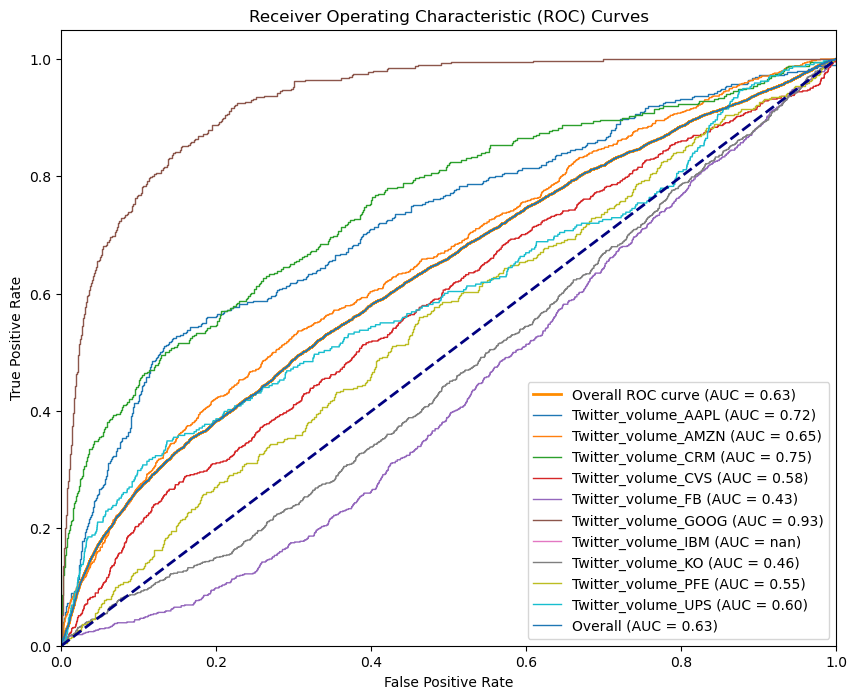


Overall ROC AUC: 0.6301


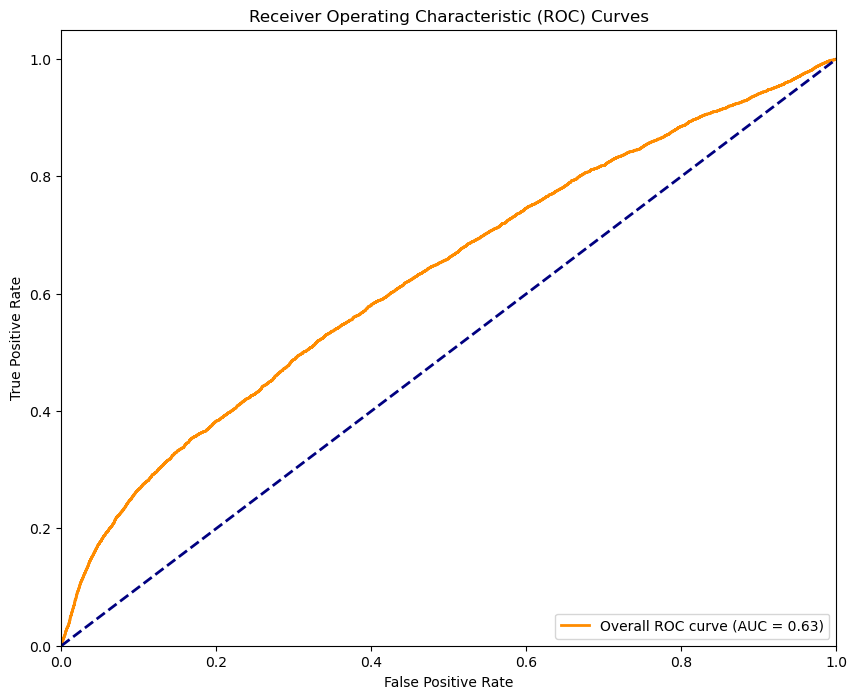

In [ ]:
# evaluation with roc curve and classification report 
from sklearn.metrics import classification_report, roc_curve, auc

model.eval()
eval_batch_size = config.eval_batch_size

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        print(f"\nProcessing directory: {dir}")
    
        # change datapath in the config
        base_config["data_path"] = data_path
        config = Config(base_config)
        
        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=sequence_length , stride=sequence_length , normalize=False)
        print("Number of batches:", len(test_dataset))

        # Create dataloader for the test dataset
        test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

        all_labels = []
        all_scores = []

        for step, (sample, labels) in enumerate(tqdm(test_dataloader)):
            std_data = torch.std(sample)
            
            with torch.no_grad():
                timesteps = torch.tensor([70])
                
                noise = torch.randn_like(sample) 
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(noisy_sample)

                # Calculate IQR outliers
                iqr_out, iqr_scores = iqr_outliers(sample, denoised_sample)
                
                labels = labels.cpu().numpy()

                # Store labels and scores
                all_labels.extend(labels.reshape(-1))
                all_scores.extend(iqr_scores.reshape(-1))

        # Calculate metrics for this directory
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        
        print("\nIQR outliers classification report for", dir)
        print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))
        print(f"ROC AUC: {roc_auc:.4f}")

        # Store results for this directory
        all_dir_results.append({
            'dir': dir,
            'labels': all_labels,
            'scores': all_scores,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        })

# Compute overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

#save the results in a csv file
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"allinone_roc_resultsf{config.num_epochs}.csv"))

# Plot overall ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')

# Plot ROC curves for each directory
for res in all_dir_results:
    plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"overall_roc_curve_{config.num_epochs}.png"))
plt.show()


In [ ]:
# ROC AUC score distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"allin_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan


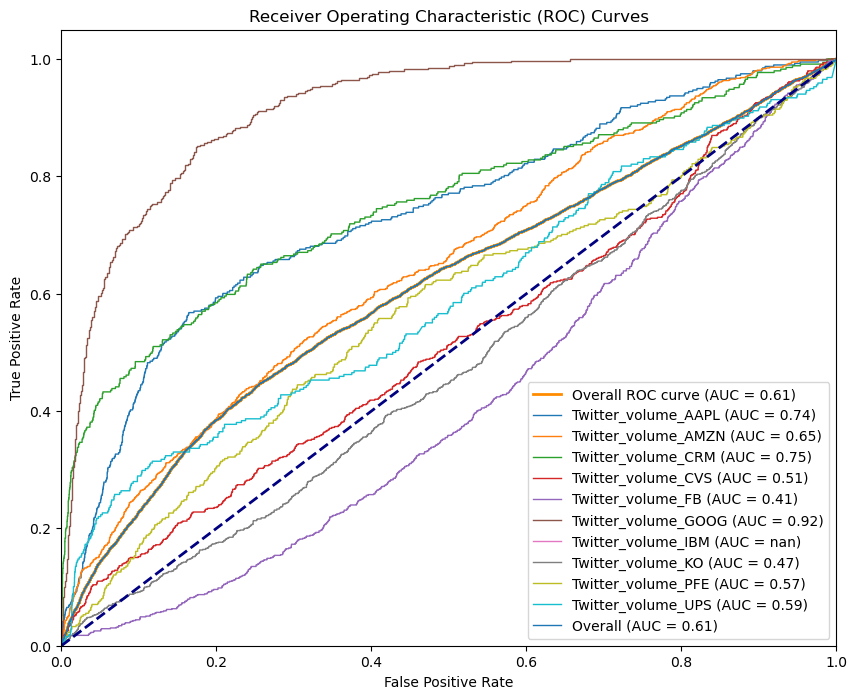

Processing directory: Twitter_volume_AAPL
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 35.64it/s]

IQR outliers classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84      5602
         1.0       0.15      0.65      0.25       398

    accuracy                           0.74      6000
   macro avg       0.56      0.69      0.54      6000
weighted avg       0.91      0.74      0.80      6000

ROC AUC: 0.7355

Processing directory: Twitter_volume_AMZN
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 33.58it/s]

IQR outliers classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.91      0.49      0.64      5208
         1.0       0.17      0.68      0.27       792

    accuracy                           0.52      6000
   macro avg       0.54      0.58      0.45      6000
weighted avg       0.81      0.52      0.59      6000

ROC AUC: 0.6455

Processing directory: Twitter_volume_CRM
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 51.49it/s]

IQR outliers classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      5651
         1.0       0.27      0.44      0.34       349

    accuracy                           0.90      6000
   macro avg       0.62      0.68      0.64      6000
weighted avg       0.92      0.90      0.91      6000

ROC AUC: 0.7483

Processing directory: Twitter_volume_CVS
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.72it/s]

IQR outliers classification report for Twitter_volume_CVS
              precision    recall  f1-score   support

         0.0       0.91      0.16      0.27      5355
         1.0       0.11      0.86      0.20       645

    accuracy                           0.24      6000
   macro avg       0.51      0.51      0.23      6000
weighted avg       0.82      0.24      0.27      6000

ROC AUC: 0.5144

Processing directory: Twitter_volume_FB
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.48it/s]

IQR outliers classification report for Twitter_volume_FB
              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80      5208
         1.0       0.07      0.13      0.09       792

    accuracy                           0.68      6000
   macro avg       0.46      0.44      0.45      6000
weighted avg       0.75      0.68      0.71      6000

ROC AUC: 0.4144

Processing directory: Twitter_volume_GOOG
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 48.63it/s]

IQR outliers classification report for Twitter_volume_GOOG

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90      5602
         1.0       0.25      0.85      0.39       398

    accuracy                           0.82      6000
   macro avg       0.62      0.84      0.64      6000
weighted avg       0.94      0.82      0.86      6000

ROC AUC: 0.9162

Processing directory: Twitter_volume_IBM
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.92it/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

IQR outliers classification report for Twitter_volume_IBM
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      6000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92      6000
   macro avg       0.50      0.46      0.48      6000
weighted avg       1.00      0.92      0.96      6000

ROC AUC: nan

Processing directory: Twitter_volume_KO
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.68it/s]

IQR outliers classification report for Twitter_volume_KO
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      4940
         1.0       0.16      0.15      0.15      1060

    accuracy                           0.71      6000
   macro avg       0.49      0.49      0.49      6000
weighted avg       0.70      0.71      0.71      6000

ROC AUC: 0.4741

Processing directory: Twitter_volume_PFE
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.92it/s]

IQR outliers classification report for Twitter_volume_PFE

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      5602
         1.0       0.11      0.20      0.14       398

    accuracy                           0.83      6000
   macro avg       0.52      0.54      0.52      6000
weighted avg       0.88      0.83      0.86      6000

ROC AUC: 0.5659

Processing directory: Twitter_volume_UPS
Number of batches: 5
100%|██████████| 1/1 [00:00<00:00, 56.32it/s]

IQR outliers classification report for Twitter_volume_UPS
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      5682
         1.0       0.15      0.27      0.19       318

    accuracy                           0.88      6000
   macro avg       0.55      0.59      0.56      6000
weighted avg       0.91      0.88      0.89      6000

ROC AUC: 0.5889

Overall IQR outliers classification report
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     54850
         1.0       0.14      0.44      0.21      5150

    accuracy                           0.72     60000
   macro avg       0.54      0.59      0.52     60000
weighted avg       0.87      0.72      0.78     60000


# NAB dataset - One by one 

In [ ]:

# Main execution
data_folder = "../datasets/UTS/NAB"
noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

all_dir_results = []

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
        result = process_directory(data_path, base_config, TCN, noise_scheduler)
        all_dir_results.append(result)

# Compute and plot overall metrics
all_labels = np.concatenate([res['labels'] for res in all_dir_results])
all_scores = np.concatenate([res['scores'] for res in all_dir_results])

print("\nOverall IQR outliers classification report")
print(classification_report(all_labels, (np.array(all_scores) > 1.5).astype(int)))

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

all_dir_results.append({
    'dir': 'Overall',
    'labels': all_labels,
    'scores': all_scores,
    'fpr': fpr,
    'tpr': tpr,
    'roc_auc': roc_auc
})

# Save results to CSV
results_df = pd.DataFrame(all_dir_results)
results_df.to_csv(os.path.join(config.output_dir, f"per_directory_roc_results_{config.num_epochs}.csv"))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for res in all_dir_results:
    if res['dir'] == 'Overall':
        plt.plot(res['fpr'], res['tpr'], color='darkorange', lw=2, label=f"Overall (AUC = {res['roc_auc']:.2f})")
    else:
        plt.plot(res['fpr'], res['tpr'], lw=1, label=f"{res['dir']} (AUC = {res['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"roc_curves_{config.num_epochs}.png"))
plt.close()

print(f"\nOverall ROC AUC: {roc_auc:.4f}")

# plot ans save only the overall roc curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Overall ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(config.output_dir, f"one_by_oneoverall_roc_curve_{config.num_epochs}.png"))
plt.show()


Processing directory: Twitter_volume_AAPL


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   7%|▋         | 1/15 [00:02<00:33,  2.39s/it]

Epoch 1/15, Loss: 39925.3481


Training:  13%|█▎        | 2/15 [00:04<00:28,  2.16s/it]

Epoch 2/15, Loss: 36393.9750


Training:  20%|██        | 3/15 [00:06<00:25,  2.08s/it]

Epoch 3/15, Loss: 34554.1631


Training:  27%|██▋       | 4/15 [00:08<00:22,  2.05s/it]

Epoch 4/15, Loss: 34638.9229


Training:  33%|███▎      | 5/15 [00:10<00:20,  2.03s/it]

Epoch 5/15, Loss: 30528.0100


Training:  40%|████      | 6/15 [00:12<00:18,  2.02s/it]

Epoch 6/15, Loss: 34872.0848


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.01s/it]

Epoch 7/15, Loss: 31028.4630


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.01s/it]

Epoch 8/15, Loss: 37768.6612


Training:  60%|██████    | 9/15 [00:18<00:12,  2.01s/it]

Epoch 9/15, Loss: 68979.0937


Training:  67%|██████▋   | 10/15 [00:20<00:10,  2.01s/it]

Epoch 10/15, Loss: 49949.5968


Training:  73%|███████▎  | 11/15 [00:22<00:08,  2.01s/it]

Epoch 11/15, Loss: 30637.8538


Training:  80%|████████  | 12/15 [00:24<00:06,  2.04s/it]

Epoch 12/15, Loss: 27657.5509


Training:  87%|████████▋ | 13/15 [00:26<00:04,  2.08s/it]

Epoch 13/15, Loss: 34157.1669


Training:  93%|█████████▎| 14/15 [00:28<00:02,  2.09s/it]

Epoch 14/15, Loss: 83042.5883


Training: 100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


Epoch 15/15, Loss: 66811.0629


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.90it/s]



Classification report for Twitter_volume_AAPL
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      5602
         1.0       0.21      0.48      0.29       398

    accuracy                           0.85      6000
   macro avg       0.59      0.68      0.60      6000
weighted avg       0.91      0.85      0.87      6000

ROC AUC: 0.7433

Processing directory: Twitter_volume_AMZN


Training:   7%|▋         | 1/15 [00:02<00:30,  2.17s/it]

Epoch 1/15, Loss: 2423.6291


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.14s/it]

Epoch 2/15, Loss: 2465.2122


Training:  20%|██        | 3/15 [00:06<00:25,  2.13s/it]

Epoch 3/15, Loss: 2143.1802


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.12s/it]

Epoch 4/15, Loss: 2446.0795


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.12s/it]

Epoch 5/15, Loss: 2588.9012


Training:  40%|████      | 6/15 [00:12<00:19,  2.12s/it]

Epoch 6/15, Loss: 1033.0705


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.12s/it]

Epoch 7/15, Loss: 921.1525


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.21s/it]

Epoch 8/15, Loss: 1043.6034


Training:  60%|██████    | 9/15 [00:19<00:13,  2.18s/it]

Epoch 9/15, Loss: 870.8257


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.16s/it]

Epoch 10/15, Loss: 1417.7665


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.14s/it]

Epoch 11/15, Loss: 856.2879


Training:  80%|████████  | 12/15 [00:25<00:06,  2.16s/it]

Epoch 12/15, Loss: 933.5363


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.15s/it]

Epoch 13/15, Loss: 1236.4597


Training:  93%|█████████▎| 14/15 [00:30<00:02,  2.14s/it]

Epoch 14/15, Loss: 925.0345


Training: 100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


Epoch 15/15, Loss: 629.1375


Testing: 100%|██████████| 2/2 [00:00<00:00, 59.07it/s]



Classification report for Twitter_volume_AMZN
              precision    recall  f1-score   support

         0.0       0.77      0.31      0.44      5208
         1.0       0.08      0.40      0.13       792

    accuracy                           0.32      6000
   macro avg       0.42      0.35      0.29      6000
weighted avg       0.68      0.32      0.40      6000

ROC AUC: 0.2833

Processing directory: Twitter_volume_CRM


Training:   7%|▋         | 1/15 [00:02<00:30,  2.16s/it]

Epoch 1/15, Loss: 15.3861


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.13s/it]

Epoch 2/15, Loss: 16.9776


Training:  20%|██        | 3/15 [00:06<00:25,  2.12s/it]

Epoch 3/15, Loss: 15.6047


Training:  27%|██▋       | 4/15 [00:08<00:23,  2.12s/it]

Epoch 4/15, Loss: 15.1973


Training:  33%|███▎      | 5/15 [00:10<00:21,  2.12s/it]

Epoch 5/15, Loss: 16.6557


Training:  40%|████      | 6/15 [00:12<00:19,  2.12s/it]

Epoch 6/15, Loss: 17.4035


Training:  47%|████▋     | 7/15 [00:14<00:16,  2.12s/it]

Epoch 7/15, Loss: 22.0646


Training:  53%|█████▎    | 8/15 [00:16<00:14,  2.12s/it]

Epoch 8/15, Loss: 13.1279


Training:  60%|██████    | 9/15 [00:19<00:12,  2.12s/it]

Epoch 9/15, Loss: 11.4095


Training:  67%|██████▋   | 10/15 [00:21<00:10,  2.12s/it]

Epoch 10/15, Loss: 15.2167


Training:  73%|███████▎  | 11/15 [00:23<00:08,  2.12s/it]

Epoch 11/15, Loss: 14.2295


Training:  80%|████████  | 12/15 [00:25<00:06,  2.12s/it]

Epoch 12/15, Loss: 14.2482


Training:  87%|████████▋ | 13/15 [00:27<00:04,  2.13s/it]

Epoch 13/15, Loss: 15.4693


Training:  93%|█████████▎| 14/15 [00:29<00:02,  2.12s/it]

Epoch 14/15, Loss: 13.9759


Training: 100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


Epoch 15/15, Loss: 14.7801


Testing: 100%|██████████| 2/2 [00:00<00:00, 58.53it/s]



Classification report for Twitter_volume_CRM
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      5651
         1.0       0.22      0.31      0.26       349

    accuracy                           0.89      6000
   macro avg       0.59      0.62      0.60      6000
weighted avg       0.91      0.89      0.90      6000

ROC AUC: 0.7030

Processing directory: Twitter_volume_CVS


Training:   7%|▋         | 1/15 [00:02<00:30,  2.18s/it]

Epoch 1/15, Loss: 1.0210


Training:  13%|█▎        | 2/15 [00:04<00:27,  2.15s/it]

Epoch 2/15, Loss: 0.7997


Training:  20%|██        | 3/15 [00:06<00:27,  2.30s/it]

Epoch 3/15, Loss: 0.6672


Training:  27%|██▋       | 4/15 [00:08<00:24,  2.23s/it]

Epoch 4/15, Loss: 0.6360


Training:  33%|███▎      | 5/15 [00:11<00:21,  2.19s/it]

Epoch 5/15, Loss: 0.7000


Training:  40%|████      | 6/15 [00:13<00:19,  2.17s/it]

Epoch 6/15, Loss: 0.7253


Training:  47%|████▋     | 7/15 [00:15<00:17,  2.15s/it]

Epoch 7/15, Loss: 0.6411


Training:  53%|█████▎    | 8/15 [00:17<00:15,  2.22s/it]

Epoch 8/15, Loss: 0.6168


Training:  60%|██████    | 9/15 [00:20<00:13,  2.26s/it]

Epoch 9/15, Loss: 0.6893


Training:  67%|██████▋   | 10/15 [00:22<00:11,  2.25s/it]

Epoch 10/15, Loss: 0.7460


Training:  73%|███████▎  | 11/15 [00:24<00:09,  2.28s/it]

Epoch 11/15, Loss: 0.6770


Training:  73%|███████▎  | 11/15 [00:25<00:09,  2.32s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_dir_results is already populated with results from each directory

# Extract AUC-ROC scores for the box plot
auc_scores = [res['roc_auc'] for res in all_dir_results if res['dir'] != 'Overall']

# Create the figure
plt.figure(figsize=(6, 8))  # Adjust the width to make it narrower

# Plot AUC-ROC box plot
sns.boxplot(y=auc_scores, color='lightpink', width=0.3)  # Reduced width for a narrower box

# Set the y-axis limits from 0 to 1
plt.ylim(0, 1)

# Customize the plot
plt.ylabel('AUC-ROC')
plt.title('Distribution of AUC-ROC Scores')

# Remove x-axis label and ticks
plt.xlabel('')
plt.xticks([])

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(config.output_dir, f"one_b_one_auc_roc_distribution_{config.num_epochs}.png"))
plt.close()

# Print summary statistics
print(f"\nAUC-ROC Score Distribution:")
print(f"Mean: {np.mean(auc_scores):.4f}")
print(f"Median: {np.median(auc_scores):.4f}")
print(f"Min: {np.min(auc_scores):.4f}")
print(f"Max: {np.max(auc_scores):.4f}")


AUC-ROC Score Distribution:
Mean: nan
Median: nan
Min: nan
Max: nan
